## Initialise Notebook

In [1]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [2]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.feature_selection import f_classif


# Plotting 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_context("talk")

c:\Github\ode-biomarker-project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [4]:
# attempt load from loading code

loading_code = 'fgfr4_model_raw_simulation'
simulation_data = data_link.get_data_from_code(loading_code)

In [5]:
loading_code = 'fgfr4_ccle_dynamic_features_v2'
dynamic_features = data_link.get_data_from_code(loading_code)

## Analysis Chain

In [6]:
## CONFIG AREA 
### OPTIONS
# aCbl vs. pSPRY2 vs. pMEK vs. SPRY2
# OR 
# PTP vs aCbl 

# folder output
folder_name = "FGFR4_Dyn_Feats_Sensitivity_Analysis"

# MAIN DEFINITIONS
target_proteins = ['aCbl', 'PTP']
plot_colors = ['red', 'blue']
# file output options 
exp_id = "v2-simple"
# plot options 
dynamic_plot_cols = 2
ncluster_plot_cols = 2
normalise_simulation_dynamics = False
save_figure = True
projection_show_legend = True
## Technical parameters 
fixed_random_seed = 42 # -1 for no seed, not implemented yet
umap_params = {
    # ADD YOUR OWN HERE 
    'random_state': fixed_random_seed
}

hbd_params = {
    # ADD YOUR OWN HERE 
    'min_cluster_size': 500,
    'min_samples': 10,
}

# validation scripts
assert len(target_proteins) >= dynamic_plot_cols, 'Not enough target proteins for the plot'
assert len(target_proteins) >= ncluster_plot_cols, 'Not enough target proteins for the plot'
assert len(target_proteins) == len(plot_colors), 'Not enough plot colors for the plot'
if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

# save parameters in a text file
with open(f'{file_save_path}{exp_id}_parameters.txt', 'w') as f:
    f.write(f'Fixed random seed: {fixed_random_seed}\n')
    f.write(f'UMAP parameters: {umap_params}\n')
    f.write(f'HDBSCAN parameters: {hbd_params}\n')
    f.write(f'Target proteins: {target_proteins}\n')
    f.write(f'Plot colors: {plot_colors}\n')
    f.write(f'Normalise simulation dynamics: {normalise_simulation_dynamics}\n')
    f.write(f'Projection show legend: {projection_show_legend}\n')
        

In [7]:
indexed_dyn_feats = dynamic_features.set_index('Unnamed: 0')
columns = indexed_dyn_feats.columns

dyn_feat_cols = ['auc', 'median', 'tfc', 'tmax', 'max', 'tmin', 'min', 'ttsv', 'tsv', 'init']

joint_dyn_feat_data = []
joint_labels = []
joint_labels_id = []


# dataFrame['column name'].str.match('string')


dyn_feat_data = []
for protein in target_proteins:
    # filter data based on "protein_" in the column name
    filtered_cols = [col for col in columns if col.startswith(protein)]
    filtered_data = indexed_dyn_feats[filtered_cols]
    dyn_feat_data.append(filtered_data)
    
for i, data in enumerate(dyn_feat_data):
    label = target_proteins[i]
    label_id = i
    for row in range(data.shape[0]):
        data_row = data.iloc[row].tolist()
        # print(label,len(data_row))
        joint_dyn_feat_data.append(data_row)
        joint_labels.append(label)
        joint_labels_id.append(label_id)
        
joint_dyn_feat_df = pd.DataFrame(joint_dyn_feat_data, columns=dyn_feat_cols) 
        
        
    

In [8]:
standard_embedding = umap.UMAP(**umap_params).fit_transform(joint_dyn_feat_df)

c:\Github\ode-biomarker-project\venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


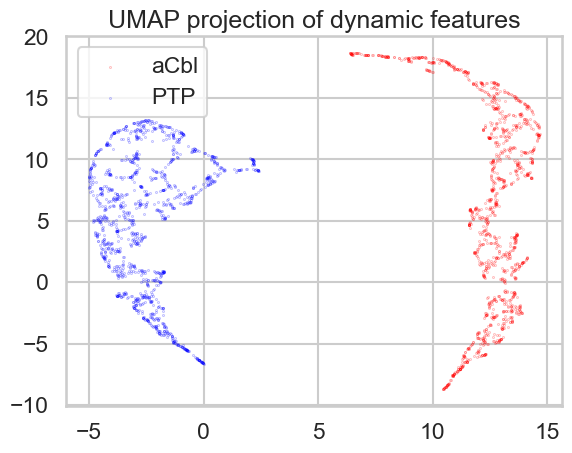

In [9]:
# plot scatter only the first label 

for k, protein in enumerate(target_proteins):
    plot_data_x = []
    plot_data_y = []
    for i, label in enumerate(joint_labels_id):
        if label == k:
            x = standard_embedding[i][0]
            y = standard_embedding[i][1]
            plot_data_x.append(x)
            plot_data_y.append(y)

    plt.scatter(plot_data_x, plot_data_y, c=plot_colors[k], s=0.1, label=protein, alpha=0.5) 
    
if projection_show_legend: plt.legend()
plt.title('UMAP projection of dynamic features')
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_dyn_feat_umap_{fixed_random_seed}.png')
plt.show()

    

In [10]:
all_celllines = simulation_data['Cellline'].unique()
all_proteins = simulation_data.columns[2:]

protein_simulation_dynamics = []

for target in target_proteins:

    protein_df_data = []
    count = 0
    for cellline in all_celllines:
        for protein in all_proteins:
            if protein == target:
                cellline_protein_data = simulation_data[(simulation_data['Cellline'] == cellline)]
                protein_data = cellline_protein_data[protein]
                protein_df_data.append(protein_data.tolist())

    time_column_df = pd.DataFrame(protein_df_data, columns=cellline_protein_data['Time'])
    protein_simulation_dynamics.append(time_column_df)
    


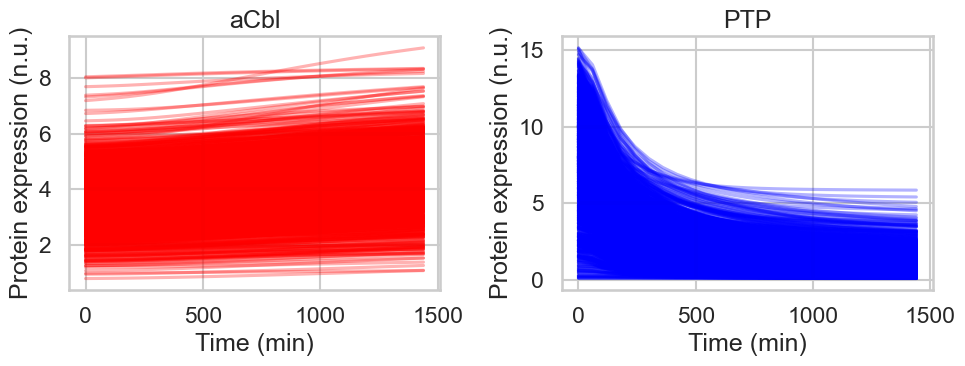

In [11]:
import math 

plot_cols = dynamic_plot_cols
plot_rows = math.ceil(len(target_proteins)/plot_cols)
plt.subplots(plot_rows, plot_cols, figsize=(5*plot_cols, 4*plot_rows))
for i, df in enumerate(protein_simulation_dynamics):
    if normalise_simulation_dynamics: 
        # perform min-max normalisation
        new_df = (df - df.min()) / (df.max() - df.min())
    plt.subplot(plot_rows, plot_cols, i+1)
    for j in range(df.shape[0]):
        if normalise_simulation_dynamics:
            plt.plot(cellline_protein_data['Time'], new_df.iloc[j], alpha=0.3, color=plot_colors[i])
        else:
            plt.plot(cellline_protein_data['Time'], df.iloc[j], alpha=0.3, color=plot_colors[i])
    plt.title(target_proteins[i])
    plt.xlabel('Time (min)')
    plt.ylabel('Protein expression (n.u.)')
plt.tight_layout()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_dyn_feat_plots_{fixed_random_seed}.png')
plt.show()

In [12]:
hbd_labels_from_dyn_feat = hdbscan.HDBSCAN(**hbd_params).fit_predict(joint_dyn_feat_df)

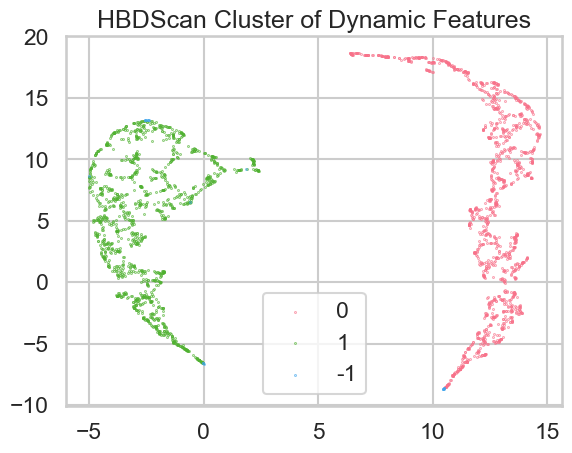

In [13]:
n_clusters = set(hbd_labels_from_dyn_feat)
plot_colors_cluster = sns.color_palette("husl", len(list(n_clusters)))

for k, cluster in enumerate(list(n_clusters)):
    plot_data_x = []
    plot_data_y = []
    for i, label in enumerate(hbd_labels_from_dyn_feat):
        if label == cluster:
            x = standard_embedding[i][0]
            y = standard_embedding[i][1]
            plot_data_x.append(x)
            plot_data_y.append(y)

    plt.scatter(plot_data_x, plot_data_y, color=plot_colors_cluster[k], s=0.2, label=cluster, alpha=0.9) 
    
if projection_show_legend: plt.legend()
plt.title('HBDScan Cluster of Dynamic Features')
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_dyn_feat_hbdscan_cluster_{fixed_random_seed}.png')
plt.show()


In [14]:
from tqdm import tqdm

# recollect the protein simulation dynamics based on new clustering 

# determine number of clusters 
n_clusters = set(hbd_labels_from_dyn_feat)
# print(len(hbd_labels_from_dyn_feat), len(joint_labels))

all_celllines = simulation_data['Cellline'].unique()
all_proteins = simulation_data.columns[2:]

protein_simulation_dynamics = []
protein_simulation_dynamics_dict = {}
for n in n_clusters: 
    protein_simulation_dynamics_dict[n] = []

count = 0
for i, protein in tqdm(enumerate(target_proteins)):

    protein_df_data = []
    for cellline in all_celllines:
        cellline_protein_data = simulation_data[(simulation_data['Cellline'] == cellline)]
        protein_data = cellline_protein_data[protein]
        cluster_group = hbd_labels_from_dyn_feat[count]
        protein_simulation_dynamics_dict[cluster_group].append(protein_data.tolist())
        count += 1 

cluster_key = []
for key, data in protein_simulation_dynamics_dict.items():
    time_column_df = pd.DataFrame(data, columns=cellline_protein_data['Time'])
    protein_simulation_dynamics.append(time_column_df)
    cluster_key.append(key)


0it [00:00, ?it/s]

2it [00:06,  3.34s/it]


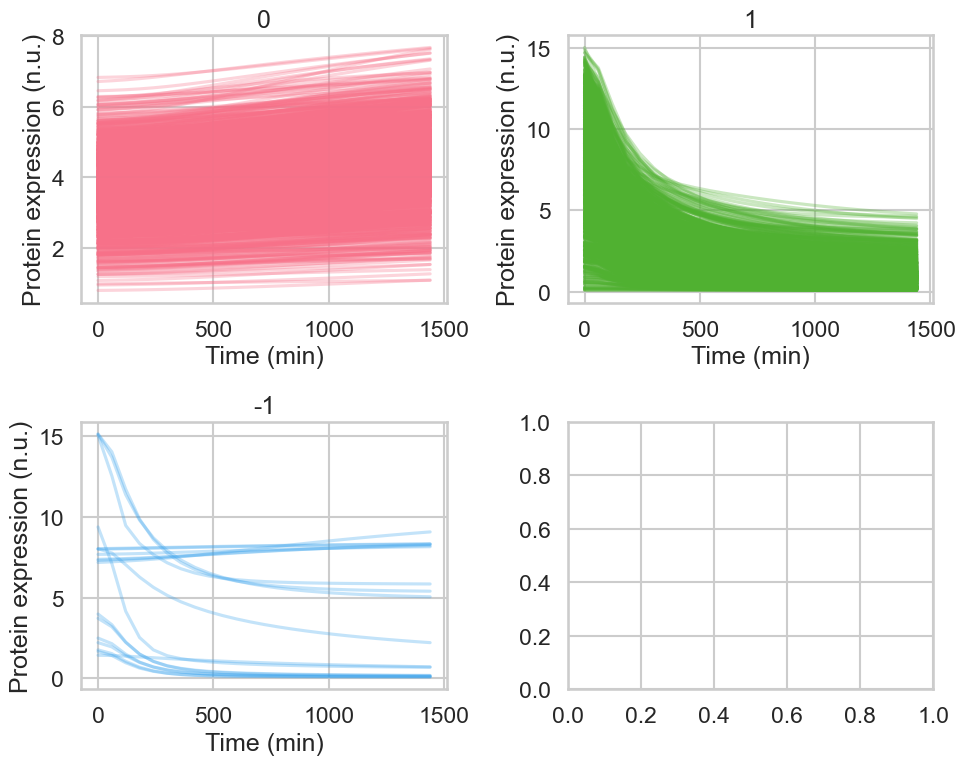

In [15]:
# spectral_color_map = plt.cm.get_cmap('Spectral')
# plot_colors_cluster = spectral_color_map(np.linspace(0, 1, len(n_clusters)))

plot_cols = ncluster_plot_cols
plot_rows = math.ceil(len(list(n_clusters))/plot_cols)

plt.subplots(plot_rows, plot_cols, figsize=(5*plot_cols, 4*plot_rows))
for i, df in enumerate(protein_simulation_dynamics):
    plt.subplot(plot_rows, plot_cols, i+1)
    if normalise_simulation_dynamics: 
        # perform min-max normalisation
        new_df = (df - df.min()) / (df.max() - df.min())
    for j in range(df.shape[0]):
        if normalise_simulation_dynamics:
            plt.plot(cellline_protein_data['Time'], new_df.iloc[j], alpha=0.3, color=plot_colors_cluster[i])
        else:
            plt.plot(cellline_protein_data['Time'], df.iloc[j], alpha=0.3, color=plot_colors_cluster[i])
    plt.title(cluster_key[i])
    plt.xlabel('Time (min)')
    plt.ylabel('Protein expression (n.u.)')
plt.tight_layout()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_dyn_feat_hbdscan_cluster_plots_{fixed_random_seed}.png')
plt.show()

In [16]:
# evaluate hbd scan clustering 

(
    adjusted_rand_score(joint_labels, hbd_labels_from_dyn_feat),
    adjusted_mutual_info_score(joint_labels, hbd_labels_from_dyn_feat)
)

(0.9872296684919847, 0.9700853283348365)

Dynamic Feature Table Grouped by Protein Specie Label

In [17]:
# segregate rows with the same joint_label_id from the joint_dyn_feat_df

def get_rows_by_label_id(labels, df: pd.DataFrame, id_):
    return df.iloc[[i for i, x in enumerate(labels) if x == id_]]

ids = list(set(joint_labels_id))

# sum_df = get_rows_by_label_id(joint_labels_id, joint_dyn_feat_df, 0)
# sum_df = sum_df.mean(axis=0)
# sum_df

new_df_data = []

for id_ in ids: 
    sum_df = get_rows_by_label_id(joint_labels_id, joint_dyn_feat_df, id_)
    sum_df = sum_df.mean(axis=0)
    new_df_data.append(sum_df.tolist())
    
new_df = pd.DataFrame(new_df_data, columns=dyn_feat_cols)

In [18]:
new_df

,auc,median,tfc,tmax,max,tmin,min,ttsv,tsv,init
0,3.875091,4.029083,0.200996,0.96,4.416316,0.00,3.708414,0.967721,4.411438,3.708414
1,2.170180,1.582467,-7.659077,0.00,7.954995,0.96,1.128401,0.932479,1.137881,7.954995


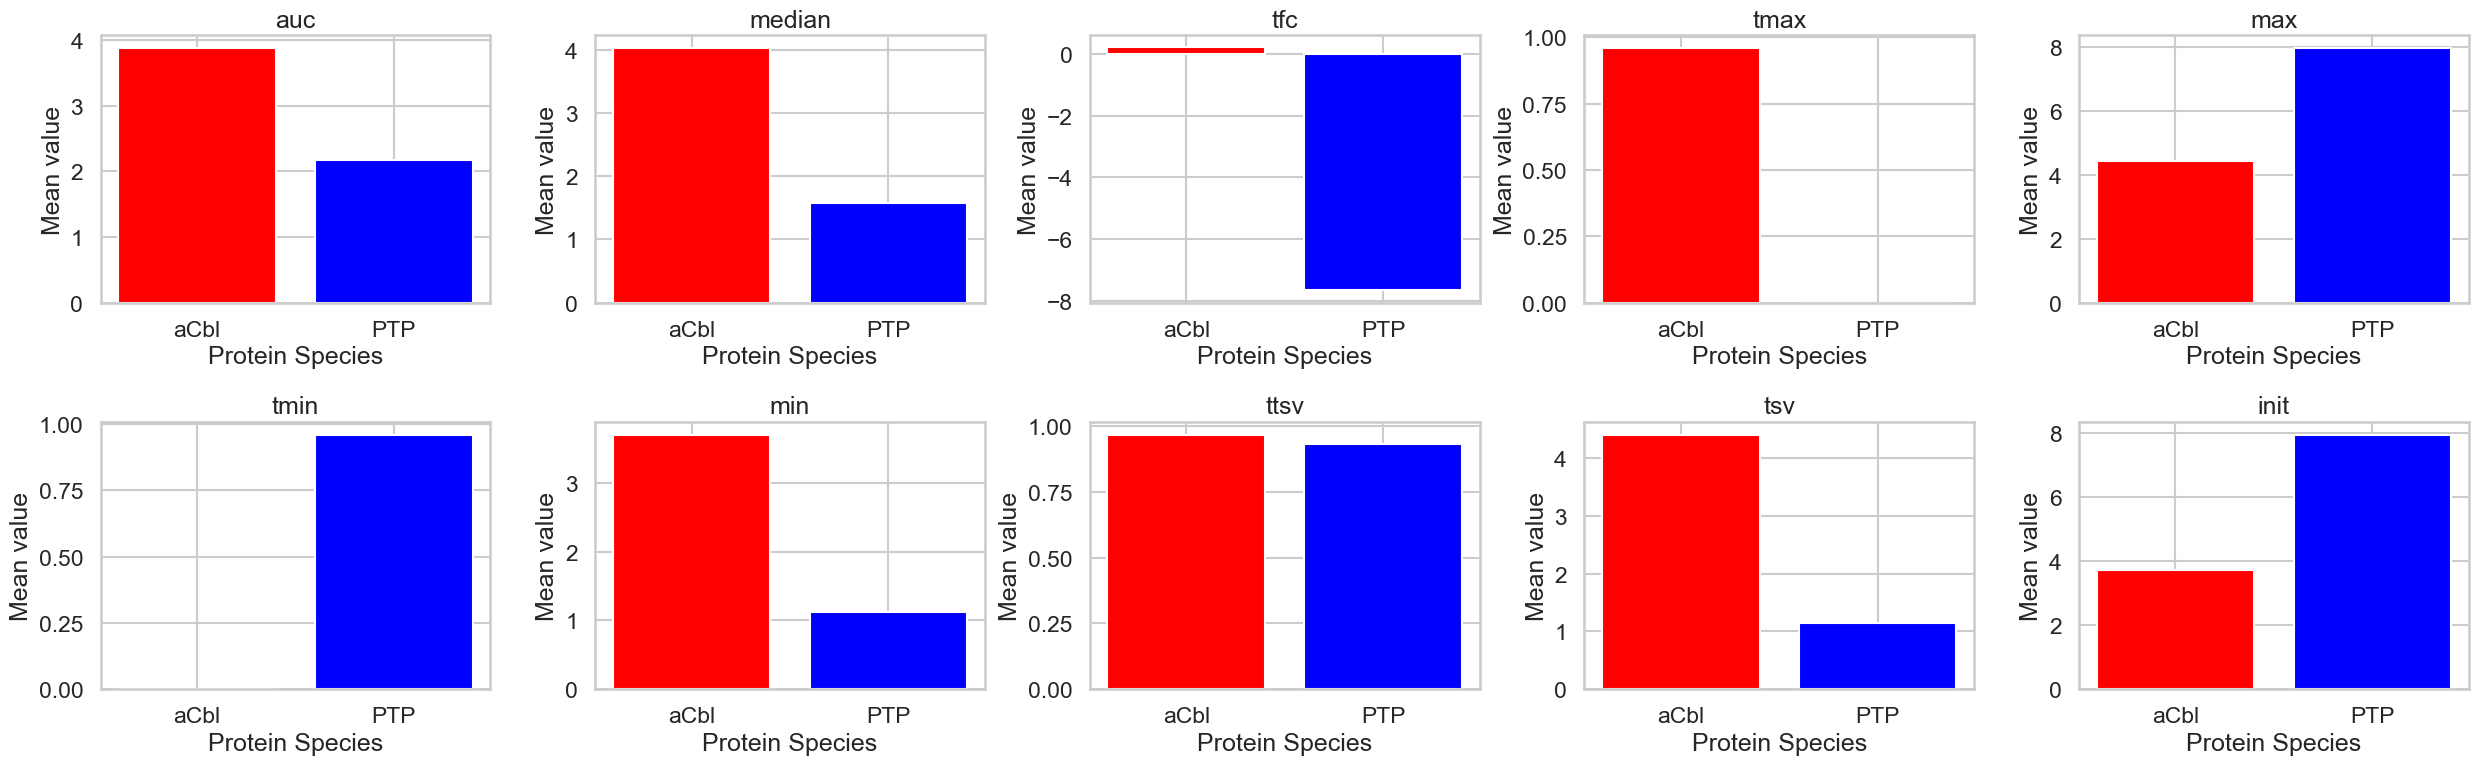

In [19]:
# display each column in a bar chart for new_df 

import math

species = target_proteins

plot_cols = 5
plot_rows = math.ceil(len(dyn_feat_cols)/plot_cols)

plt.subplots(plot_rows, plot_cols, figsize=(5*plot_cols, 4*plot_rows))
for i, col in enumerate(dyn_feat_cols):
    plt.subplot(plot_rows, plot_cols, i+1)
    plt.bar(target_proteins, new_df[col], color=plot_colors)
    plt.title(col)
    plt.xlabel('Protein Species')
    plt.ylabel('Mean value')
    
plt.tight_layout()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_dyn_feat_bar.png')

Automatic Knockout Studies

In [20]:
f_scores = f_classif(joint_dyn_feat_df, joint_labels)

f_score_df = pd.DataFrame(f_scores, columns=dyn_feat_cols)

In [21]:
# format the output such that it is easier to read
f_score_df = f_score_df.T
f_score_df.columns = ['F value', 'p value']
f_score_df = f_score_df.sort_values(by='F value', ascending=False)
# when displaying, show only 3 decimal places
f_score_df = f_score_df.round(2)
f_score_df.head(10)

,F value,p value
tsv,7.967240e+03,0.0
tfc,7.451950e+03,0.0
min,5.553860e+03,0.0
median,3.888820e+03,0.0
init,1.992100e+03,0.0
auc,1.672990e+03,0.0
max,1.360840e+03,0.0
ttsv,3.571000e+01,0.0
tmax,-2.609190e+16,NaN
tmin,-2.609190e+16,NaN


In [22]:
f_score_list = f_score_df['F value'].tolist()


In [23]:
f_score_list_label = f_score_df.index.tolist()